# Problem 2: Bundles

# Part 1: Lloyd

In [ ]:
# help from https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670
# and https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
import numpy as np
import random
from numpy.linalg import norm

class KMeans:
  def __init__(self, k, max_iter):
    self.k = k
    self.max_iter = max_iter
    self.centroids = []
    self.clusters = []
    self.cost = None

  def euclidean(self, point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

  def find_cluster(self, dist):
    return np.argmin(dist, axis=1)

  def init_centroids(self, data):
    ''' Does an initial population of self.centroids '''
    # do random init
    self.centroids = [random.choice(data)]

    for i in range(self.k-1):
      dists = np.sum([self.euclidean(centroid, data) for centroid in
                      self.centroids], axis=0)
      dists /= np.sum(dists)
      new_centroid = np.random.choice(range(data.shape[0]), size=1, p=dists)
      self.centroids += [data[new_centroid[0]]]

    self.centroids = np.asarray(self.centroids)

  def find_centroids(self, data, prev):
    ''' Calculates and updates centroids '''
    self.centroids = [np.mean(cluster, axis=0) for cluster in self.clusters]
    for i, centroid in enumerate(self.centroids):
      if np.isnan(centroid).any():
        # catch any nan centroids, caused by lack of points
        self.centroids[i] = prev[i]
    self.centroids = np.asarray(self.centroids)
  
  def find_clusters(self, data):
    ''' Computes distance of points and assigns clusters '''
    self.clusters = [[] for _ in range(self.k)]
    for x in data:
      dists = self.euclidean(x, self.centroids)
      centroid_i = np.argmin(dists)
      self.clusters[centroid_i].append(x)

  def find_cost(self, data):
    ''' Computes and assigns cost '''
    dist = []
    for i in range(self.k):
      dist += [(point - self.centroids[i]) for point in self.clusters[i]]
    self.cost = np.sum(np.square(dist))

  def fit(self, data):
    self.init_centroids(data)
    i = 0
    prev_centroids = None

    while not np.all(self.centroids == prev_centroids) and i < self.max_iter:
      prev_centroids = self.centroids
      self.find_clusters(data)
      self.find_centroids(data, prev_centroids)
      i += 1
    
    self.find_cost(data)

  def predict(self, data):
    centroids = []
    centroid_is = []
    for x in data:
      dists = self.euclidean(x, self.centroids)
      centroid_i = np.argmin(dists)
      centroids.append(self.centroids[centroid_i])
      centroid_is.append(centroid_i)

    return centroids, centroid_is


In [2]:
# get PCA data
import pandas as pd

pca_df = pd.read_csv('https://raw.githubusercontent.com/f1nn3g4n/RandomCSVs/main/PCA_data.csv')
pca_label = pd.read_csv('https://raw.githubusercontent.com/f1nn3g4n/RandomCSVs/main/PCA_label.csv')
train_x = pca_df.to_numpy()
train_y = pca_label['0'].to_numpy()

In [ ]:
kmeans = KMeans(2, 3)
kmeans.fit(train_x)

In [ ]:
# code and constants for plotting kmeans w centroids
import matplotlib.pyplot as plt

def plot_kmeans(kmeans):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1,1,1)
  for clust in kmeans.clusters:
    xs = [x for x, _, _, _ in clust]
    ys = [y for _, y, _, _ in clust]    
    plt.scatter(xs, ys, cmap='rainbow')
  plt.plot([x for x, _, _, _ in kmeans.centroids],
           [y for _, y, _, _ in kmeans.centroids],
           'ko', markersize=10)
  plt.title('KMeans clustering with %d clusters' % kmeans.k)
  plt.show()

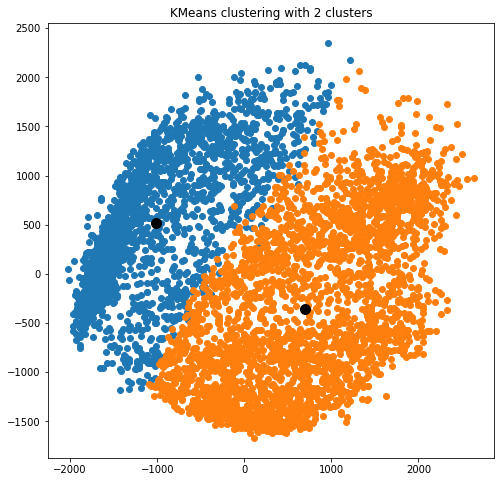

In [ ]:
plot_kmeans(kmeans)

For this plot and later plots, I use the first two values for each point. Given that each point has 4 values, this made the most sense for 2D plots.


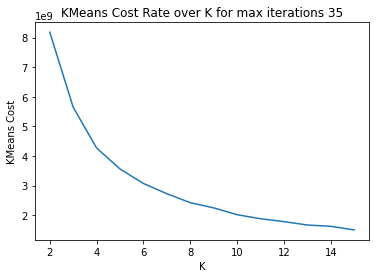

In [ ]:
import pdb
# plotting error of increasing k
cost = []

for i in range(2, 16):
  min_cost = 0
  for j in range(3):
    kmeans2 = KMeans(i, 35)
    kmeans2.fit(train_x)
    if kmeans2.cost < min_cost or j == 0:
      min_cost = kmeans2.cost
  cost.append(min_cost)

plt.plot(range(2,16),cost)
plt.ylabel('KMeans Cost')
plt.xlabel('K')
plt.title('KMeans Cost Rate over K for max iterations 35')
plt.show()

Looking at the cost rate above, I believe around k=6 is an optimal choice for number of clusters, given the curve somewhat elbows there.

Knowing the true labels for the data, this makes sense for the elbow to be here. Since shirts, pullovers, t-shirts, etc. are similar in appearance, it will be difficult to cluster them separately. 

In [ ]:
kmeans2 = KMeans(6, 30)
kmeans2.fit(train_x)

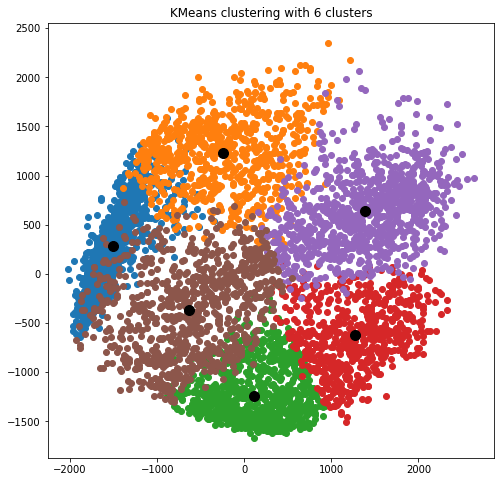

In [ ]:
plot_kmeans(kmeans2)

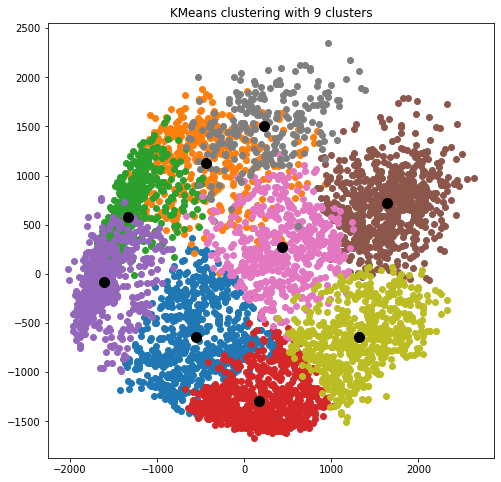

In [ ]:
kmeans3 = KMeans(9,30)
kmeans3.fit(train_x)
plot_kmeans(kmeans3)

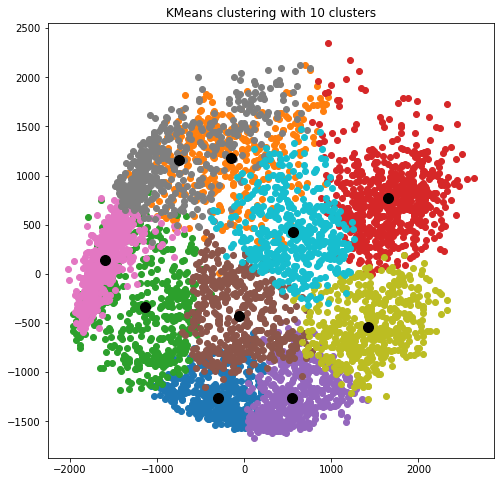

In [ ]:
kmeans4 = KMeans(10, 30)
kmeans4.fit(train_x)
plot_kmeans(kmeans4)

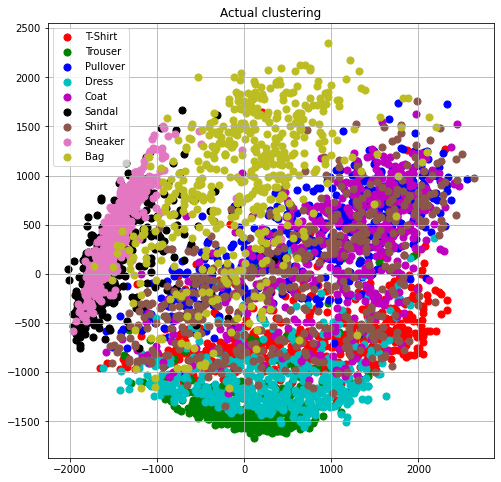

In [ ]:
colors = ['r','g','b','c','m','k','tab:brown','tab:pink','tab:olive']
fashion_dict = {0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress",
                4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 
                8: "Bag", 9: "Ankle boot"}
targets = fashion_dict.values()
labels = fashion_dict.keys()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for target, color, lab in zip(targets, colors, labels):
  ax.scatter(train_x[train_y == lab][:,0],
              train_x[train_y == lab][:,1],
              c=color,
              s=50)
ax.legend(targets)
plt.title('Actual clustering')
ax.grid()

For k ≤ 10, shown by the plots with k = 6 and k = 9 above, the clusters start to resemble the true label clustering (shown in the last plot). They fail to have the same accuracy with overlap, however. 

At k = 10, we have more clusters than labels, but we also get a closer resemblance to the overlap from the true labels.

All that said, where there is the most overlap with the true labels is for items that are similar in appearance (like sneaker and sandal). Arguably, with k = 6, we see decent clustering with this consideration. These similar looking objects are clustered together there, and the cluster separation better reflects the more diverse objects.

# Part 2: Hague

In [7]:
# help from: https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/
# and lab8

from sklearn.cluster import AgglomerativeClustering as ac
from scipy.cluster.hierarchy import dendrogram, linkage

# using n_clusters = 6 from elbow method
s_clust = ac(n_clusters = 6, affinity='euclidean', linkage='single')
a_clust = ac(n_clusters = 6, affinity='euclidean', linkage='average')
s_clust.fit_predict(train_x)
a_clust.fit_predict(train_x)

print('Single link cluster labels\n', s_clust.labels_)
print()
print('Average link cluster labels\n', a_clust.labels_)

Single link cluster labels
 [0 0 0 ... 0 0 0]

Average link cluster labels
 [0 5 1 ... 2 5 5]


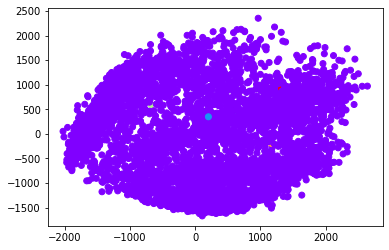

In [ ]:
plt.scatter(train_x[:,0], train_x[:,1], c=s_clust.labels_, cmap='rainbow')

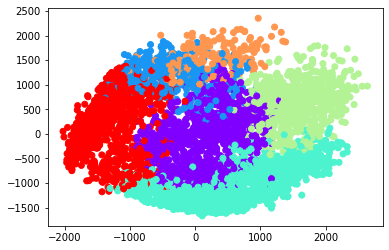

In [ ]:
plt.scatter(train_x[:,0], train_x[:,1], c=a_clust.labels_, cmap='rainbow')

Clearly using average linkage outputs a much more representative clustering, compared to the true labels, shown below.

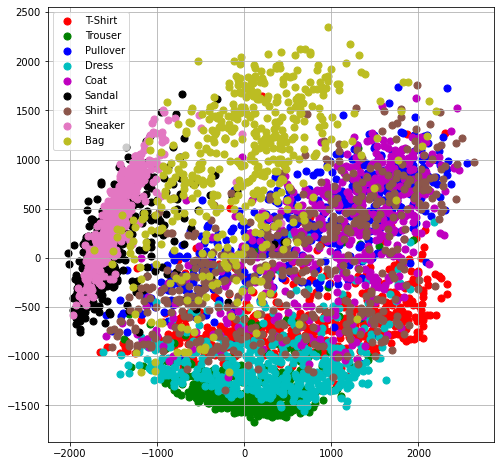

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for target, color, lab in zip(targets, colors, labels):
  ax.scatter(train_x[train_y == lab][:,0],
              train_x[train_y == lab][:,1],
              c=color,
              s=50)
ax.legend(targets)
ax.grid()

Similarly, below we can see a comparison in dendrograms.

In [3]:
# Normalization
from sklearn.preprocessing import MinMaxScaler 
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(train_x) 

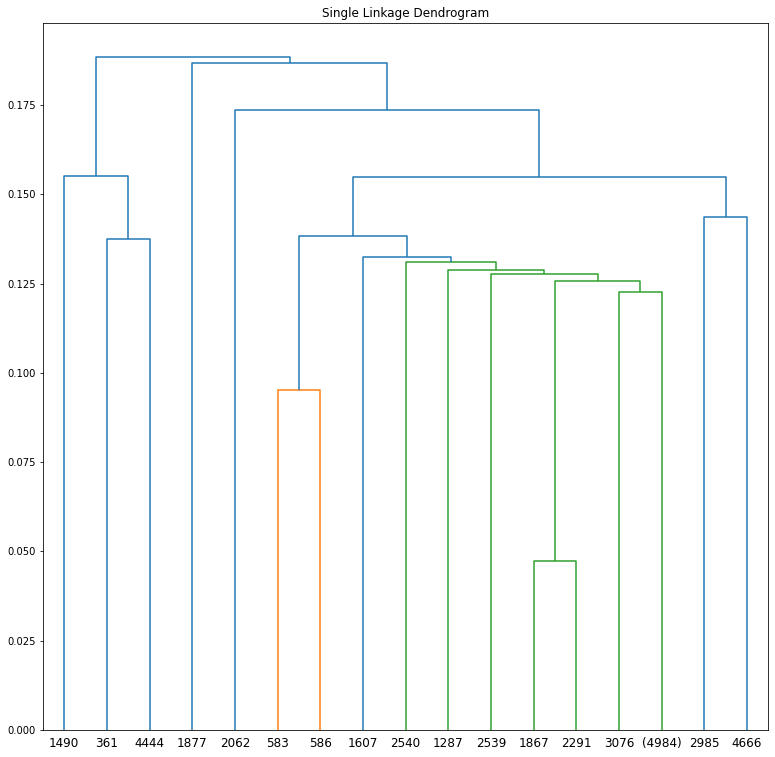

In [8]:
plt.figure(figsize=(13,13))
plt.title("Single Linkage Dendrogram")
dend = dendrogram(linkage(scaled, method='single'), p=10, truncate_mode='level')

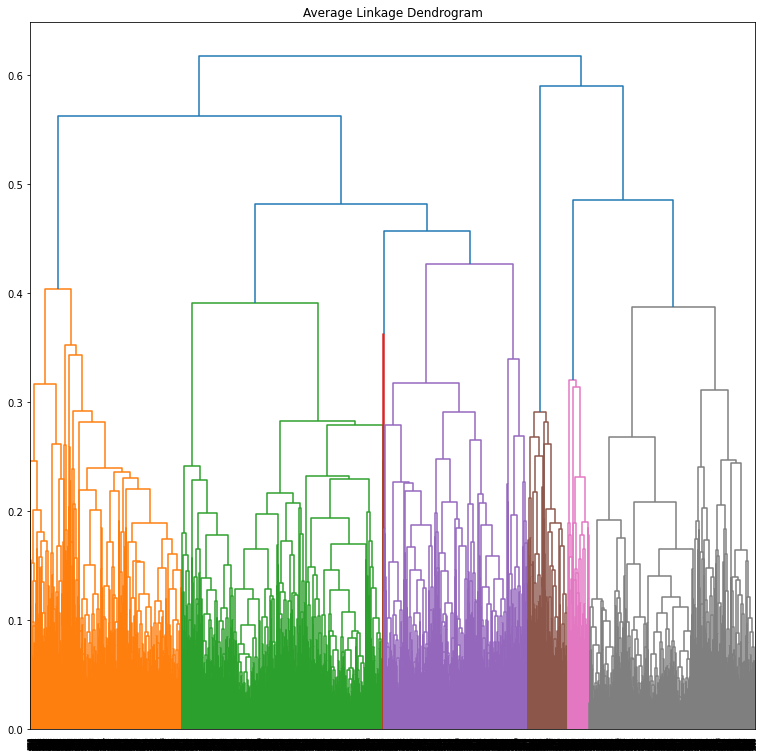

In [ ]:
plt.figure(figsize=(13,13))
plt.title("Average Linkage Dendrogram")
dend = dendrogram(linkage(scaled, method='average'))

A single linkage dendrogram was not even possible without truncation, given the dataset. 

As for final clustering, I would make the cut a bit below 0.4 on the y-axis. This would give us 11 clusters. There is significant difference for many of these cluster splits (e.g., between the brown and pink subtrees). Going much lower would split less significantly different clusters and run a higher risk of overfitting. 

We do have more clusters than true labels here. We could not include the green and gray splits to get 9 clusters. However, given the difference in clusters, I think the added 2 clusters will help better the model for further data.